# Anomaly Detection
## Imports and Loading Dataset

The dataset is sampled from random gaussian distributions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
X1 = np.load('data/X1.npy')
X1_1 = np.load('data/X1_1.npy') # Variable X1 with far outlier
X2 = np.load('data/X2.npy')
df = pd.DataFrame()
df['X1'] = X1
df['X1_1'] = X1_1
df['X2'] = X2

In [4]:
df.head()

,X1,X1_1,X2
0,12.662034,12.662034,-6.607371
1,-9.890820,-9.890820,4.638357
2,-7.646777,-7.646777,4.984616
3,-4.753542,-4.753542,-2.287770
4,8.975483,8.975483,7.568073


## Plot functions

In [5]:
def plotAnomalies1D(s, anomalies, threshold1, threshold2):
    """
        s: Pandas Series containing all the points to plot
        anomalies: Pandas Series containing all the points which are anomalies
        threshold1: Float value - minimum threshold to be normal
        threshold2: Float value - maximum threshold to be normal
    """
    plt.figure()
    plt.plot(s, [0]*len(s), 'bo')
    plt.plot(anomalies, [0]*len(anomalies), 'ro')
    plt.plot([threshold1]*2, [-1,1], 'g--')
    plt.plot([threshold2]*2, [-1,1], 'g--')

In [6]:
def plotAnomalies2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    plt.figure()
    plt.plot(df['X1'],df['X2'], 'o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([df['X1'].min()-3,df['X1'].max()+3])
    plt.ylim([df['X2'].min()-3,df['X2'].max()+3])
    plt.title(clf_name)
    
    if clf_name == 'LOF':
        ypred = clf.fit_predict(df[['X1','X2']])
        plt.plot(df['X1'][ypred==-1],df['X2'][ypred==-1],'ro')
    else:
        xx, yy = np.meshgrid(np.linspace(df['X1'].min()-3,df['X1'].max()+3, 500), np.linspace(df['X2'].min()-3,df['X2'].max()+3, 500))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')

In [7]:
def plotAnomalyScore2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df[['X1','X2']])
    
    plt.figure()
    sc = plt.scatter(x=df['X1'],y=df['X2'], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(clf_name)

## Univariate Outlier Detection

In this section, let's consider a single variable x = X1. Let's visualize the dataset in different ways...

In [8]:
x = 'X1'

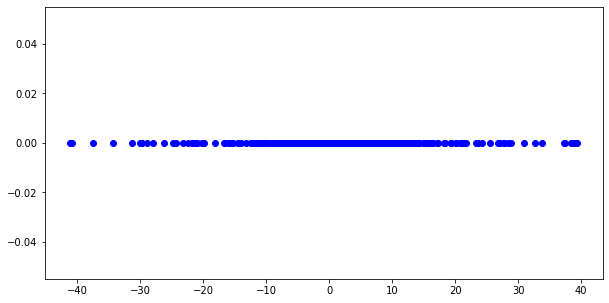

In [9]:
# Scatter plot
plt.figure()
plt.plot(df[x], [0]*len(df), 'bo')

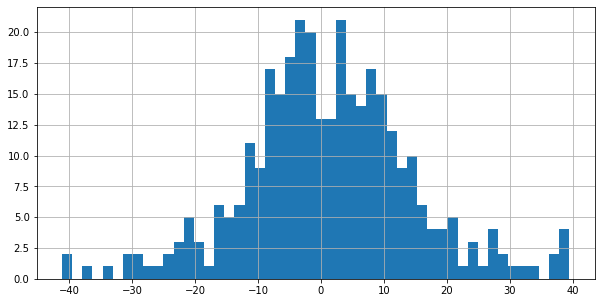

In [10]:
# Histogram
df[x].hist(bins=50)

In [11]:
# Key statistical indicators
df[x].describe()

count    330.000000
mean       1.119313
std       13.497184
min      -41.112042
25%       -6.482452
50%        0.676623
75%        8.979254
max       39.395503
Name: X1, dtype: float64

Implement your own 1D outlier detection method. To do this, you need to compute:
- <em>threshold1</em> : Float value - minimum threshold to be normal
- <em>threshold2</em> : Float value - maximum threshold to be normal
- <em>anomalies</em> : Pandas Series containing all the points which are anomalies

In [12]:
# Using Mean & std
mu = df[x].mean()
sig = df[x].std()

threshold1 = mu - 2*sig
threshold2 = mu + 2*sig
anomalies = df[x][(df[x] - mu).abs() > 2*sig].copy()

In [13]:
# Using Median and MAD
med = df[x].median()
mad = (df[x] - med).abs().median()

threshold1 = med - 3*mad
threshold2 = med + 3*mad
anomalies = df[x][(df[x] - med).abs() > 3*mad].copy()

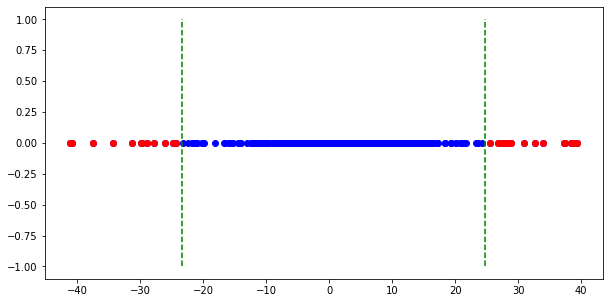

In [14]:
plotAnomalies1D(df[x], anomalies, threshold1, threshold2)

## Multivariate Outlier Detection

In this section, let's consider 2 variables X1 and X2. Let's visualize the dataset.

Text(0, 0.5, 'X2')

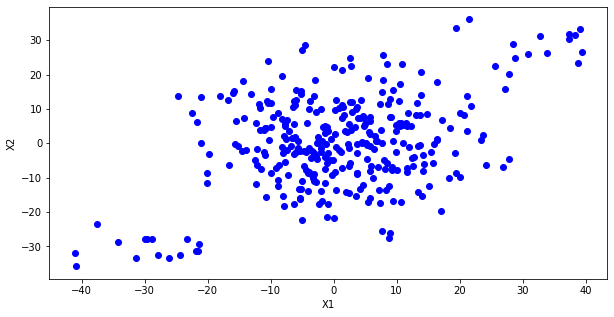

In [15]:
plt.figure()
plt.plot(df['X1'],df['X2'], 'bo')
plt.xlabel('X1')
plt.ylabel('X2')

We will experiment here with the 4 different outlier detection methods we have just seen in class. These methods are directly available in Scikit-Learn.

In [16]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [17]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df[['X1','X2']])

EllipticEnvelope(assume_centered=False, contamination=0.15, random_state=None,
                 store_precision=True, support_fraction=None)

In [18]:
clf_name = 'Isolation Forest'
clf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.15)
clf.fit(df[['X1','X2']])

IsolationForest(behaviour='new', bootstrap=False, contamination=0.15,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [19]:
clf_name = 'Local Outlier Factor'
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.15)
clf.fit(df[['X1','X2']])

LocalOutlierFactor(algorithm='auto', contamination=0.15, leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=5, novelty=False, p=2)

In [20]:
clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3) # nu corresponds to contamination
clf.fit(df[['X1','X2']])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.15, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

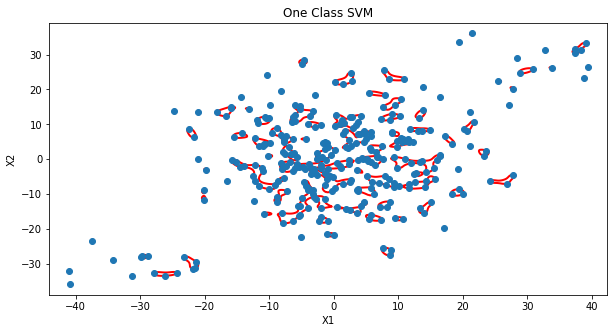

In [21]:
plotAnomalies2D(df, clf_name, clf)

Let's compute and visualize, for each model, the continuous anomaly scores.

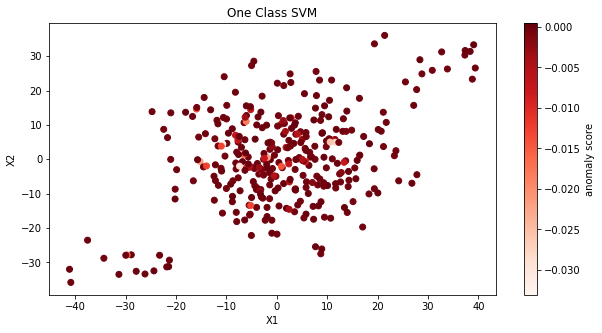

In [22]:
plotAnomalyScore2D(df, clf_name, clf)

## Novelty Detection

In this section, we split the dataset to have on one side the normal points, and on the other side the new points which are anomalies.

In [23]:
normal_df = df.iloc[:300].copy()
new_anomalies = df.iloc[300:].copy()

Text(0, 0.5, 'X2')

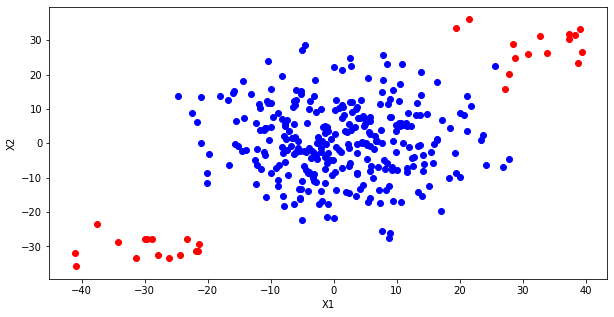

In [24]:
plt.figure()
plt.plot(normal_df['X1'], normal_df['X2'], 'bo')
plt.plot(new_anomalies['X1'], new_anomalies['X2'], 'ro')
plt.xlabel('X1')
plt.ylabel('X2')

The purpose of novelty detection is to learn the behavior of normal points. We can use unsupervised methods such as those we have seen earlier, but we can also use supervised learning.

To do this, you have to select a supervised model $\tilde{f}$ to learn the relationship between X1 and X2. 

$$
\tilde{X}_2 = \tilde{f}\left(X_1\right)
$$You need to compute:
- <em>ypred_normal</em> : an array containing the predicted values for the normal dataset
- <em>ypred_anomalies</em> : an array containing the predicted values for the new anomalies dataset

In [25]:
X = np.array(normal_df['X1']).reshape(-1,1)
y = np.array(normal_df['X2'])

In [26]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=200, max_depth=20)
regr.fit(X, y)

ypred_normal = regr.predict(np.array(normal_df['X1']).reshape(-1,1))
ypred_anomalies = regr.predict(np.array(new_anomalies['X1']).reshape(-1,1))


Let's visualize the superposition of actual values and the predicted values, as scatter plot.

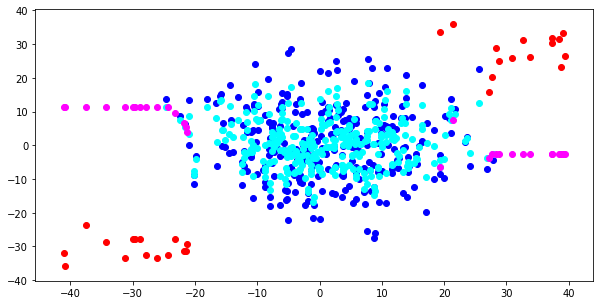

In [27]:
# Superposition
plt.figure()
plt.scatter(x=normal_df['X1'],y=normal_df['X2'],c='b')
plt.scatter(x=normal_df['X1'],y=ypred_normal,c='cyan')

plt.scatter(x=new_anomalies['X1'],y=new_anomalies['X2'],c='r')
plt.scatter(x=new_anomalies['X1'],y=ypred_anomalies,c='magenta')

We can also look at the predicted values versus the actual values, for normal and anomaly points.

Text(0, 0.5, 'Predicted values')

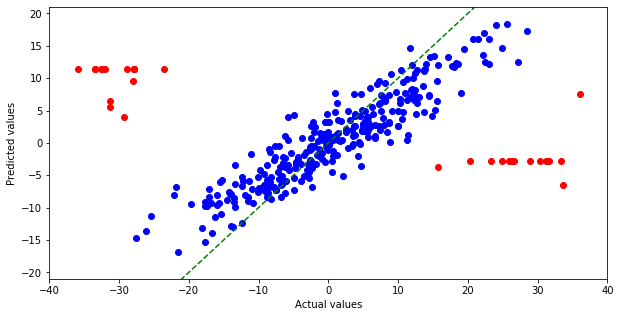

In [28]:
# Value / Value plot
plt.figure()
plt.scatter(x=normal_df['X2'], y=ypred_normal, c='b')
plt.scatter(x=new_anomalies['X2'], y=ypred_anomalies,c='r')
plt.plot([-50,50], [-50,50], 'g--')
plt.xlim([-40,40])
plt.ylim([-21,21])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

In [32]:
error_normal = (normal_df['X2'] - ypred_normal)**2
error_anomalies = (new_anomalies['X2'] - ypred_anomalies)**2

Finally, let's visualize the prediction error as color levels.

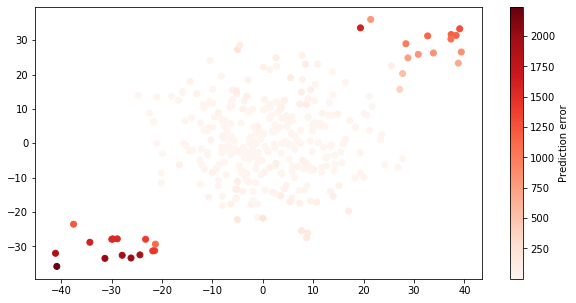

In [31]:
plt.figure()
sc = plt.scatter(x=list(normal_df['X1']) + list(new_anomalies['X1']), 
            y=list(normal_df['X2']) + list(new_anomalies['X2']), 
            c=list(error_normal) + list(error_anomalies),
            cmap='Reds')
plt.colorbar(sc, label='Prediction error')

It looks like a pretty good anomaly score!